In [2]:
import torch
import pyro

In [3]:
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os
smoke_test = ('CI' in os.environ)

In [4]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
exp_transform = T.ExpTransform()

In [5]:
dist_y = dist.TransformedDistribution(dist_x, [exp_transform])

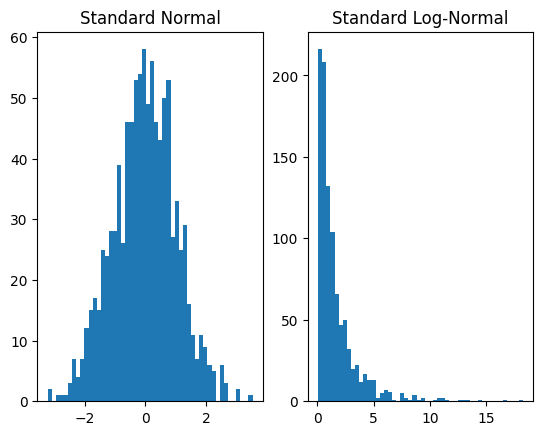

In [6]:
plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Standard Log-Normal')
plt.show()

In [7]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
affine_transform = T.AffineTransform(loc=3, scale=0.5)
exp_transform = T.ExpTransform()
dist_y = dist.TransformedDistribution(dist_x, [affine_transform, exp_transform])

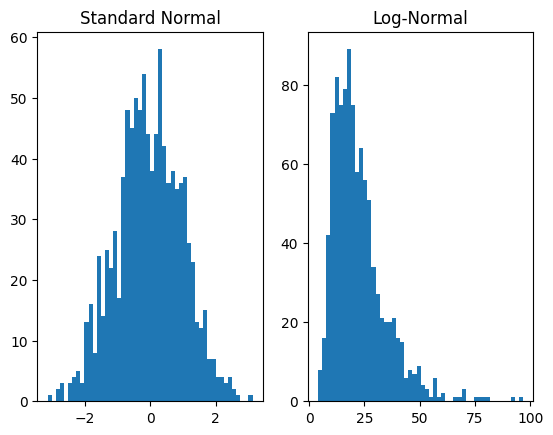

In [8]:
plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Log-Normal')
plt.show()

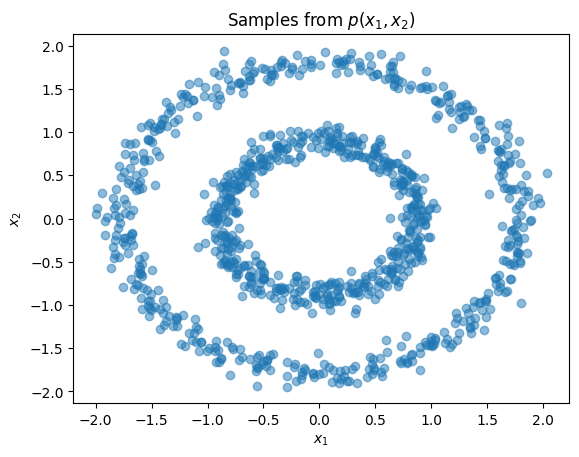

/var/folders/ht/g0df3gd950q_7vrlxkgv43fw0000gn/T/ipykernel_32138/3530957513.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[:,0], hist=False, kde=True,
/var/folders/ht/g0df3gd950q_7vrlxkgv43fw0000gn/T/ipykernel_32138/3530957513.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns

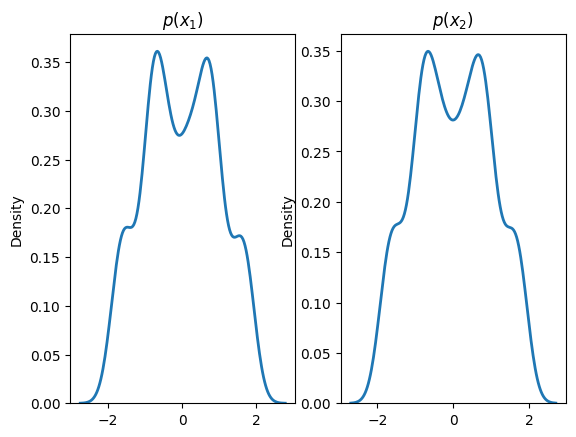

In [9]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show()

In [10]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.Spline(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [11]:
%%time
steps = 1 if smoke_test else 1001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 4.27247953414917
step: 200, loss: 1.3861639499664307
step: 400, loss: 1.2971116304397583
step: 600, loss: 1.288717269897461
step: 800, loss: 1.2848559617996216
step: 1000, loss: 1.2819167375564575
CPU times: user 1.44 s, sys: 488 ms, total: 1.92 s
Wall time: 1.63 s


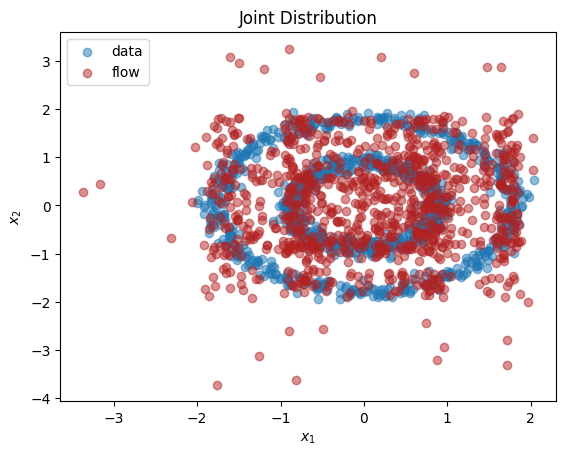

/var/folders/ht/g0df3gd950q_7vrlxkgv43fw0000gn/T/ipykernel_32138/3152742130.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[:,0], hist=False, kde=True,
/var/folders/ht/g0df3gd950q_7vrlxkgv43fw0000gn/T/ipykernel_32138/3152742130.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns

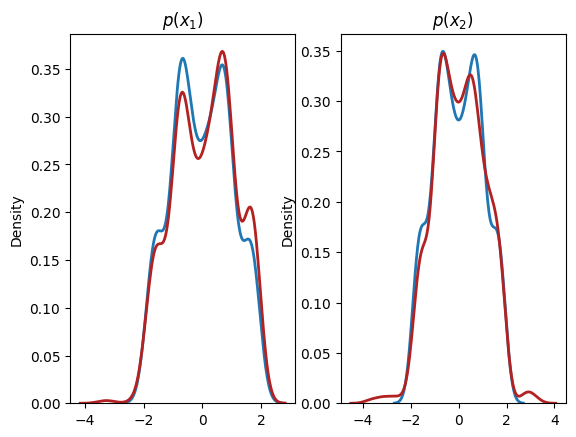

In [12]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

In [13]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [14]:
%%time
steps = 1 if smoke_test else 5001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.266007661819458
step: 500, loss: 1.8578877449035645
step: 1000, loss: 2.0416884422302246
step: 1500, loss: 1.7678395509719849
step: 2000, loss: 1.7513706684112549
step: 2500, loss: 1.745092511177063
step: 3000, loss: 1.8589447736740112
step: 3500, loss: 1.6745880842208862
step: 4000, loss: 1.7163821458816528
step: 4500, loss: 1.6615517139434814
step: 5000, loss: 1.7140859365463257
CPU times: user 16.1 s, sys: 2.73 s, total: 18.8 s
Wall time: 16.7 s


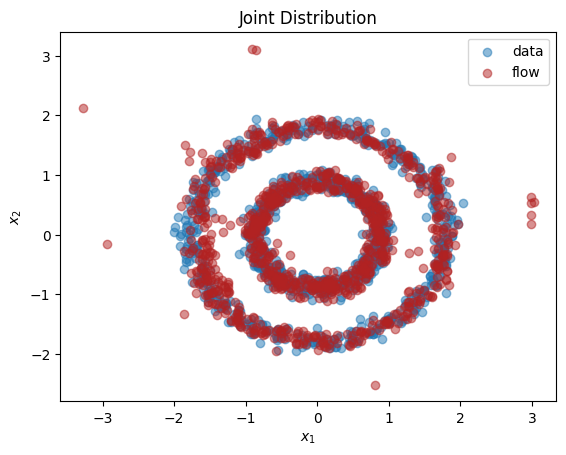

/var/folders/ht/g0df3gd950q_7vrlxkgv43fw0000gn/T/ipykernel_32138/3152742130.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[:,0], hist=False, kde=True,
/var/folders/ht/g0df3gd950q_7vrlxkgv43fw0000gn/T/ipykernel_32138/3152742130.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns

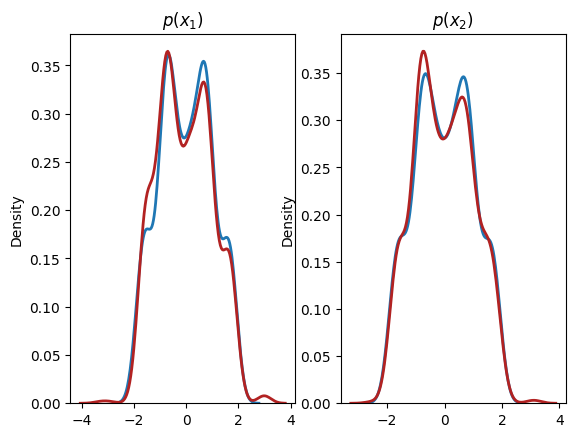

In [15]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

In [16]:
dist_base = dist.Normal(torch.zeros(1), torch.ones(1))
x1_transform = T.spline(1)
dist_x1 = dist.TransformedDistribution(dist_base, [x1_transform])

In [17]:
x2_transform = T.conditional_spline(1, context_dim=1)
dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [x2_transform])

In [18]:
x1 = torch.ones(1)
print(dist_x2_given_x1.condition(x1).sample())

tensor([1.3240])


In [19]:
%%time
steps = 1 if smoke_test else 5001
modules = torch.nn.ModuleList([x1_transform, x2_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=3e-3)
x1 = dataset[:,0][:,None]
x2 = dataset[:,1][:,None]
for step in range(steps):
    optimizer.zero_grad()
    ln_p_x1 = dist_x1.log_prob(x1)
    ln_p_x2_given_x1 = dist_x2_given_x1.condition(x1.detach()).log_prob(x2.detach())
    loss = -(ln_p_x1 + ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_x1.clear_cache()
    dist_x2_given_x1.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.7814717292785645
step: 500, loss: 2.143033504486084
step: 1000, loss: 1.939209222793579
step: 1500, loss: 1.9053055047988892
step: 2000, loss: 1.9029165506362915
step: 2500, loss: 1.8659977912902832
step: 3000, loss: 1.8655816316604614
step: 3500, loss: 1.8245222568511963
step: 4000, loss: 1.8228437900543213
step: 4500, loss: 1.840376853942871
step: 5000, loss: 1.8118948936462402
CPU times: user 12.8 s, sys: 463 ms, total: 13.2 s
Wall time: 12.8 s


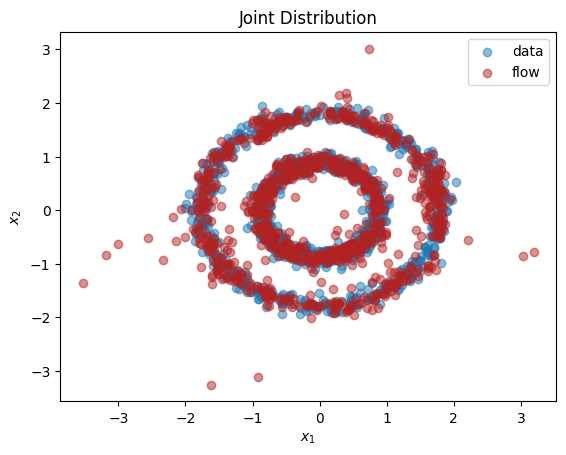

/var/folders/ht/g0df3gd950q_7vrlxkgv43fw0000gn/T/ipykernel_32138/3403572020.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[:,0], hist=False, kde=True,
/var/folders/ht/g0df3gd950q_7vrlxkgv43fw0000gn/T/ipykernel_32138/3403572020.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns

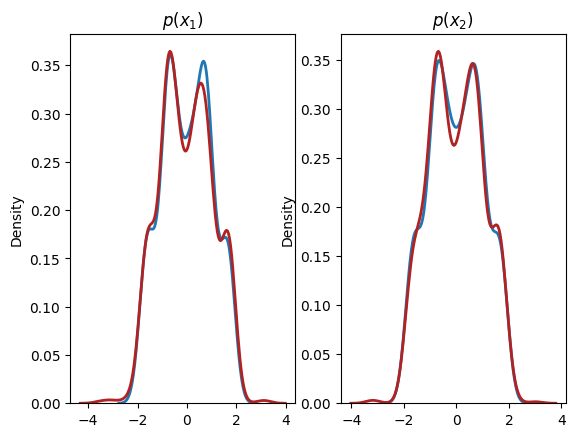

In [20]:
X = torch.cat((x1, x2), dim=-1)
x1_flow = dist_x1.sample(torch.Size([1000,]))
x2_flow = dist_x2_given_x1.condition(x1_flow).sample(torch.Size([1000,]))
X_flow = torch.cat((x1_flow, x2_flow), dim=-1)

plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()